# Limber Checks using CAMB

In [ ]:
import numpy as np
import camb
from camb import model, initialpower
from sys import exit
#
# Set basic parameters

omch2 = 0.12038
ombh2 = 0.022032
h = 0.67556 #H0/100
cspeed = 299792.458 # km/s
A_s = 2.215e-9
n_s = 0.9619
tau_reion = 0.079
neff=3.046

H0 = 67.556  # km/s/Mpc


kmax   = 10  #kmax to use
zmax   = 2.0
ellmax = 2000
nell   = 400
#
# redshift bin 1
mu_z1    = 0.8
sigma_z1 = 0.1
# redshift bin 2
mu_z2    = 1.2
sigma_z2 = 0.1
#
ns = 4.0 # number of sigma in integration
nz = 400 #number of steps to use for the radial/redshift integration
#
def norm_gaussian(x,mu,sigma):
    return 1.0/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-0.5*(x-mu)**2/sigma**2)
#
#First set up parameters as usual
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
pars.InitPower.set_params(ns=0.965)
#
#For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
#so get background results to find chistar, set up a range in chi, and calculate corresponding redshifts
results= camb.get_background(pars)
#
#Get the matter power spectrum interpolation object (based on RectBivariateSpline).
#Here for lensing we want the power spectrum of the Weyl potential.
# see https://camb.readthedocs.io/en/latest/results.html
# and https://camb.readthedocs.io/en/latest/transfer_variables.html#transfer-variables
PK = camb.get_matter_power_interpolator(pars, nonlinear=False,
    hubble_units=False, k_hunit=False, kmax=kmax, zmax=zmax)
#
z1  = np.linspace(mu_z1-ns*sigma_z1,mu_z1+ns*sigma_z1,num=nz,endpoint=False) # should use better integrator formula
z2  = np.linspace(mu_z2-ns*sigma_z2,mu_z2+ns*sigma_z2,num=nz,endpoint=False)
dz1 = z1[1]-z1[0]
dz2 = z2[1]-z2[0]
#
ellarr = np.linspace(2,ellmax,nell)
resarr = np.zeros(np.size(ellarr))
for il, ell in enumerate(ellarr):
    res = 0.0
    for iz in z1:
        chi_iz = results.comoving_radial_distance(iz) # returns comoving radial distance chi in Mpc
        kz     = (0.5+ell)/chi_iz
        Pkz    = PK.P(iz, kz, grid=False)
        W_iz   = norm_gaussian(iz,mu_z1,sigma_z1)
        for jz in z2:
            chi_jz = results.comoving_radial_distance(jz) # returns comoving radial distance chi in Mpc
            W_jz   = norm_gaussian(jz,mu_z2,sigma_z2)
            res    = res + W_iz*(1.0+iz)*Pkz*W_jz*(chi_jz-chi_iz)/(chi_jz*chi_iz)
    res = res*(1.0+ell)*ell/(0.5+ell)**2
    res = res*1.5*(omch2+ombh2)*100.0**2/cspeed**2 # units 1/Mpc^2
    resarr[il]=res*dz1*dz2
    print(ell,res)
#
#
#Get angular power spectrum for galaxy number counts and lensing
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
#
pars.set_for_lmax(ellmax, lens_potential_accuracy=2)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = False
#NonLinear_both or NonLinear_lens will use non-linear corrections
#pars.NonLinear = model.NonLinear_both
pars.NonLinear = model.NonLinear_none
#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
pars.SourceWindows = [
    GaussianSourceWindow(redshift=mu_z1, source_type='counts', bias=1.0, sigma=sigma_z1, dlog10Ndm=0.4),
    GaussianSourceWindow(redshift=mu_z2, source_type='lensing', sigma=sigma_z2)]
#
results = camb.get_results(pars)
cls = results.get_source_cls_dict()
clx = cls['W1xW2']
ls=  np.arange(2, ellmax+1)
#
# Save results to output file for visualisation elsewhere
np.savez_compressed('cl_cross_limber.npz',l_limber=ellarr,cl_limber=resarr)
np.savez_compressed('cl_cross_camb.npz',l_camb=ls,cl_camb=clx)
#
#


# Plots

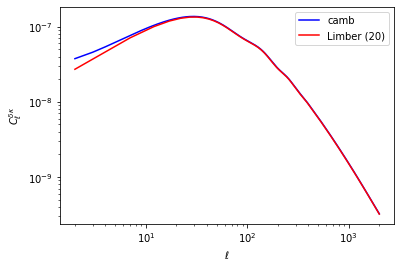

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

data_camb = np.load('cl_cross_camb.npz')
data_limber = np.load('cl_cross_limber.npz')

l_limber  = data_limber['l_limber']
cl_limber = data_limber['cl_limber']
l_camb    = data_camb['l_camb']
cl_camb   = data_camb['cl_camb']

plt.loglog(l_camb[:2000],cl_camb[2:2001]/(l_camb[:2000]*(l_camb[:2000]+1.0))*2.0*np.pi, color='b',label='camb')
plt.plot(l_limber,cl_limber,color='r',label='Limber (20)')
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell^{\delta\kappa}$')
plt.legend()



Text(0, 0.5, 'relative difference camb - Limber')

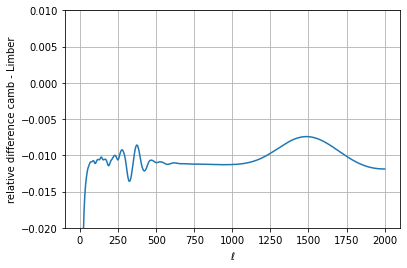

In [4]:
l1 = l_camb[:2000]
cl1 = cl_camb[2:2001]/(l_camb[:2000]*(l_camb[:2000]+1.0))*2.0*np.pi
cl_c_f = interp1d(l1,cl1,kind='cubic')
cl_c_intp = cl_c_f(l_limber)

dcl = (cl_limber-cl_c_intp)/(cl_limber+cl_c_intp)*2.0

plt.plot(l_limber,dcl)
plt.ylim((-0.02,0.01))
plt.grid()
plt.xlabel('$\ell$')
plt.ylabel('relative difference camb - Limber')